# Part 13: Verify that the created streets are unique
Added streets could be replicas of existing streets
michael babb
2025 09 23 

In [1]:
# standard
import os

In [2]:
# external
import geopandas as gpd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# custom
from geo_data_io.fc_df_spatial import write_gdf
import run_constants as rc
from utils import create_city_sector, create_name

In [4]:
# custom
import run_constants as rc
from utils import create_name, generate_street_end_vertices
from geo_data_io.fc_df_spatial import keep_largest_geometry, write_gdf

# Load the data

In [5]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S02_SND_COMPLETE_OUT_FILE_NAME)
fpn

'../../../project/seattle_streets/data\\Street_Network_Database_Complete_Revised.gpkg'

In [6]:
c_gdf = gpd.read_file(filename = fpn)

In [7]:
c_gdf.dtypes

f_intr_id                          int64
t_intr_id                          int64
snd_id                             int64
snd_feacode                        int64
citycode                           int64
stname_id                          int64
st_code                            int64
arterial_code                      int64
segment_type                       int64
agency_code                        int64
access_code                        int64
divided_code                       int64
structure_type                     int64
legalloc_code                      int64
vehicle_use_code                   int64
gis_seg_length                   float64
l_adrs_from                        int64
l_adrs_to                          int64
r_adrs_from                        int64
r_adrs_to                          int64
ord_pre_dir                       object
ord_street_name                   object
ord_street_type                   object
ord_suf_dir                       object
ord_stname_conca

In [8]:
# create a graph

In [9]:
sg = nx.from_pandas_edgelist(df = c_gdf,
source = 'f_intr_id', target = 't_intr_id', edge_attr = True)

In [10]:
sg.number_of_nodes()

23251

# load the added streets

In [11]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S05_MISSING_IN_FILE_NAME)
fpn

'../../../project/seattle_streets/data\\missing_segments_v2.gpkg'

In [12]:
gdf = gpd.read_file(filename = fpn)

In [13]:
gdf.dtypes

snd_id                      int64
ord_street_name            object
ord_street_type            object
ord_stname_type            object
ord_stname_concat          object
ord_stname_unique          object
ord_stname_type_group      object
ord_street_type_rank       object
snd_group                   int64
group_id                    int64
city_sector                object
city_sector_group          object
street_status               int64
sn_id                       int64
en_id                       int64
dist                      float64
dist_miles                float64
geometry                 geometry
dtype: object

In [14]:
# now, compare the data, by node id to node id

In [15]:
def find_existing_segments(row):
    return int(sg.has_edge(u = row['sn_id'], v = row['en_id']))

In [16]:
gdf['existing_segment'] = gdf.apply(func = find_existing_segments, axis = 1)

In [17]:
gdf['n_segments'] = int(1)

In [18]:
# do a pivot!
pv_df = pd.pivot_table(data = gdf, 
                       values = 'n_segments',
                       index = 'street_status',
                       columns = 'existing_segment',
                       aggfunc='sum',
                       fill_value = 0,
                       margins = True).reset_index()
pv_df.columns = ['street_status', 'not_existing', 'is_existing', 'total']

In [19]:
# apply descriptions to the street_status

In [20]:
gdf['street_status_desc'] = gdf['street_status'].map(rc.street_status_dict)

In [21]:
gdf['street_status_reclass'] = gdf['street_status'].astype(str) + '_' + gdf['existing_segment'].astype(str)

In [22]:
gdf['street_status_reclass_desc'] = gdf['street_status_reclass'].map(rc.extended_street_status_dict)

In [23]:
# save it to disk

In [24]:
# let's save
write_gdf(gdf = gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name='missing_segments_v3.gpkg')

# Simple Stats about the added streets

In [27]:
gdf['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21931
continuous_street               3825
added_street: within-sector     3614
added_street: cross-sector       410
Name: count, dtype: int64

In [29]:
gdf['street_status_reclass_desc'].value_counts()

street_status_reclass_desc
discontinuous_street                         21931
continuous_street                             3825
added_street: within-sector, not existing     2806
added_street: within-sector, existing          808
added_street: cross-sector, not existing       393
added_street: cross-sector, existing            17
Name: count, dtype: int64

# MAKE A BIG DUMB PLOT OF THE DIFFERENCES IN WITHIN-SECTOR CONNECTED STREETS

In [30]:
# compute logs of distance
gdf['dist_miles_log'] = np.log10(gdf['dist_miles'])

In [31]:
##
# stack the original and the reclassified streets - this is used to generate the histograms
##
df_list = []

# the original classification
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status', 'street_status_desc']
tdf = gdf.loc[gdf['street_status'] == 2, col_names]
tdf['street_status'] = gdf['street_status'].astype(str)
df_list.append(tdf)

# the reclassed streets
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status_reclass', 'street_status_reclass_desc']
tdf = gdf.loc[gdf['street_status'] == 2, col_names]
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status', 'street_status_desc']
tdf.columns = col_names 
df_list.append(tdf)
tdf = pd.concat(objs = df_list, axis = 0)

In [32]:
##
# CREATE A DATAFRAME THAT HOLDS ALL OF THE SUMMARY STATISTICS
##

In [33]:
# ds 1: averages
# ds 2: added segments by type
# ds 3: unique roads

In [34]:
##
# Descriptive Statistic 01: average segment length and positioning for each group
##
col_names = ['street_status', 'street_status_desc', 'dist_miles']
ds_df = tdf[col_names].groupby(col_names[:-1]).agg(avg_dist_miles = ('dist_miles', 'mean')).reset_index()
ds_df['avg_dist_miles_log'] = np.log10(ds_df['avg_dist_miles'])
ds_df['avg_dist'] = ds_df['avg_dist_miles'] * 5280
ds_df['color'] = ['#000000', '#ca0020', '#b88b0b'] # these colors are used throughout
ds_df['avg_text'] = ['0.23 mi (avg.)', '0.29 mi (avg.)',  '145 ft (avg.)']
ds_df['avg_text_ha'] = ['right', 'left', 'center']
ds_df['avg_text_x_pos'] = ds_df['avg_dist_miles_log']
# the horizontal position is created from the distance in miles and the text jitter


In [35]:
##
# Descriptive Statistic 02: what roads have only new segments and/or only existing segment?
##
# pivot to get membership by street type
ss_df = pd.pivot_table(data = gdf, index = ['ord_stname_concat'],
                 columns = ['street_status_reclass'],
                 values = ['n_segments'],aggfunc = 'sum', fill_value = 0)
# new columns
ss_df.columns = ['continuous', 'discontinuous', 'asws_new', 'asws_ex', 'asis_new', 'asis_ex']

# rescale to 1 if GT 1
ss_df = ss_df.map(func = lambda x: 1 if x > 1 else x)
def unpack_it(row):
    return '_'.join([str(rv) for rv in row.to_numpy()])

ss_df['combined_class'] = ss_df.apply(unpack_it, axis = 1)

# these are the street combos of interest
voi = ['0_1_1_0_0_0', '0_1_1_1_0_0', '0_1_0_1_0_0']
ss_df = ss_df.loc[ss_df['combined_class'].isin(voi), 'combined_class'].value_counts().to_frame(name = 'n_unique_roads').reset_index()

# add street status for joining
ss_df['street_status'] = ['2_0', '2', '2_1']
ds_df = pd.merge(left = ds_df, right = ss_df)

# Descriptive Statistic 02: segment status and histogram 
ds_df['seg_stat_desc'] =  ['added', 'new', 'existing']
ds_df['seg_stat_alpha'] =  [0.2, 0.8, 0.8]
ds_df['seg_stat_xy_text'] =  [(-3.15, 160), (-3.15, 145), (-3.15, 130)]
ds_df['foreground_color'] =  ['white', 'white', 'white']

In [36]:
# Descriptive Statistic 03: unique roads
ds_df['ur_desc'] = ['new and existing segments', 'only new segments',  'only existing segments']
ds_df['ur_xy_text'] = [(-3.15, 100), (-3.15, 85), (-3.15, 70)]

In [37]:
ss = '2'
ds_dict = ds_df.loc[ds_df['street_status'] == ss, :].to_dict(orient = 'records')[0]
ds_dict

{'street_status': '2',
 'street_status_desc': 'added_street: within-sector',
 'avg_dist_miles': 0.23005073625172942,
 'avg_dist_miles_log': -0.6381763724858979,
 'avg_dist': 1214.6678874091313,
 'color': '#000000',
 'avg_text': '0.23 mi (avg.)',
 'avg_text_ha': 'right',
 'avg_text_x_pos': -0.6381763724858979,
 'combined_class': '0_1_1_1_0_0',
 'n_unique_roads': 399,
 'seg_stat_desc': 'added',
 'seg_stat_alpha': 0.2,
 'seg_stat_xy_text': (-3.15, 160),
 'foreground_color': 'white',
 'ur_desc': 'new and existing segments',
 'ur_xy_text': (-3.15, 100)}

2
2_0
2_1
..\graphics\histogram_ws_ALL_streets_revised.png


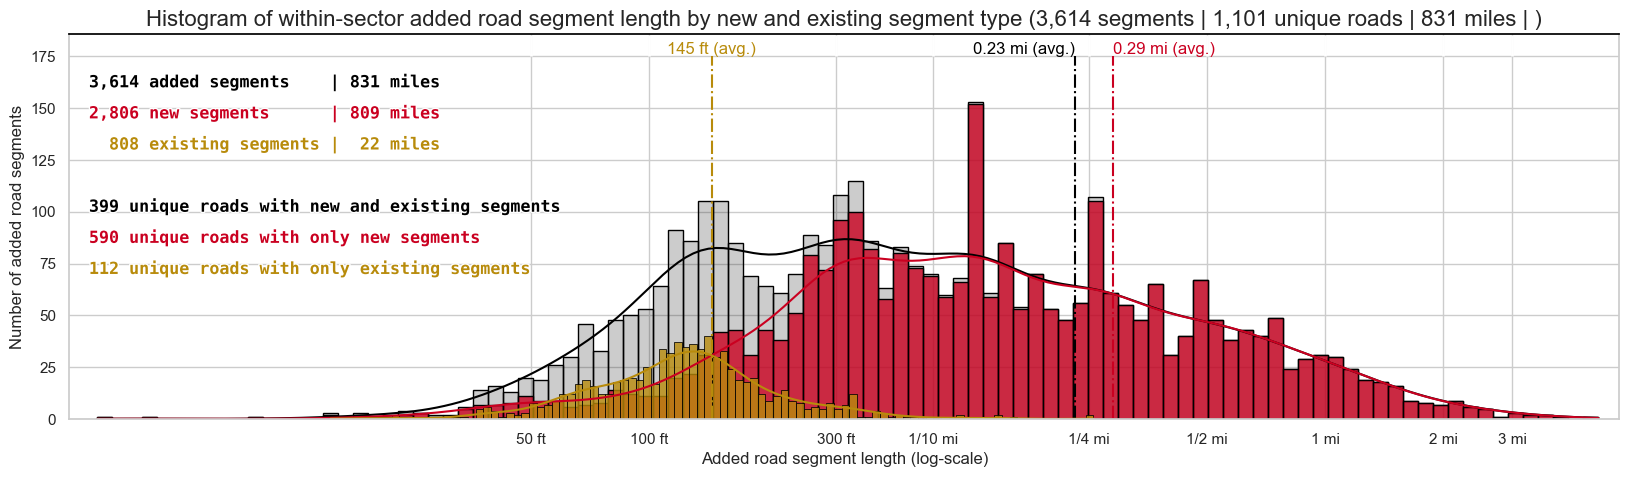

In [38]:
# start your plots
# top to bottom
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)
ax.set_xlim(-3.2, .75)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

# y ticks
y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

ax.set_yticks(ticks = y_ticks)
ax.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# x tick positions - need to log transform to match the inputs
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']

ax.set_xticks(ticks = x_ticks)
ax.set_xticklabels(labels = x_tick_label_text, rotation=0)

# add separate histograms for each group.
# This way we can control the alpha transparency for each histogram
for ss in tdf['street_status'].unique():
    print(ss)
    
    # current working df
    adf = tdf.loc[tdf['street_status'] == ss, :]

    # total unique roads
    total_unique_roads = f"{adf['ord_stname_concat'].unique().shape[0]:,}"
    total_miles = f"{int(round(adf['dist_miles'].sum(), 0)):,}"
    total_segments = f"{adf.shape[0]:,}"

    # place the descriptive stats and plotting options into a dictionary
    ds_dict = ds_df.loc[ds_df['street_status'] == ss, :].to_dict(orient = 'records')[0]
    
    # create a color palette of the form 'data_category':'color
    color_palette = {ss:ds_dict['color']}    

    # add the histogram
    ax1 = sns.histplot(
        data=adf,
        x="dist_miles_log",
        hue="street_status",
        palette=color_palette,
        element='bars',
        multiple = 'layer',
        bins = 100,
        edgecolor = 'black',
        alpha = ds_dict['seg_stat_alpha'],
        legend=None,
        kde = True
    )

    ##
    # DESCRIPTIVE STATISTICS 1: Average segment length
    ##
    # add vertical lines at some descriptive statistics points
    ax.vlines(x = ds_dict['avg_dist_miles_log'], ymin = 0, ymax = 175, color = ds_dict['color'], linestyles = 'dashdot')

    # add text for the descriptive stats    
    ax.text(x = ds_dict['avg_text_x_pos'], y = 176, s = ds_dict['avg_text'], horizontalalignment = ds_dict['avg_text_ha'], color = ds_dict['color'])

    ##
    # DESCRIPTIVE STATISTICS 2: Segment status
    ##
    # add the text describing the mileage
    desc_text = f"{total_segments.rjust(5)} {ds_dict['seg_stat_desc']} segments".ljust(24) + F"| {total_miles.rjust(3)} miles"
            
    txt = ax.annotate(text = desc_text, xy = ds_dict['seg_stat_xy_text'],
                color = ds_dict['color'], fontsize = 12,
                fontweight = 'bold', fontstretch = 'extra-expanded', fontfamily = 'monospace')
    
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground=ds_dict['foreground_color']),
        path_effects.Normal()
        ])
    
    ##
    # DESCRIPTIVE STATISTICS 3: Unique road counts
    ##
    # add some text with the road counts

    # add the text describing the mileage
    desc_text = f"{ds_dict['n_unique_roads']} unique roads with {ds_dict['ur_desc']}"
            
    txt = ax.annotate(text = desc_text, xy = ds_dict['ur_xy_text'],
                color = ds_dict['color'], fontsize = 12,
                fontweight = 'bold', fontstretch = 'extra-expanded', fontfamily = 'monospace')
    
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])    

# white out the top portion of the ticks
for xt in x_ticks:
    ax.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)

##
# BUILD THE TITLE
##
asws_df = gdf.loc[gdf['street_status'] == 2, ]

# segments
n_added = asws_df.shape[0]
n_added =  f"{n_added:,}"

tot_miles = asws_df['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

unique_roads = asws_df['ord_stname_concat'].unique().shape[0]
unique_roads = f"{unique_roads:,}"

my_title = f"Histogram of within-sector added road segment length by new and existing segment type ({n_added} segments | {unique_roads} unique roads | {tot_miles} miles | )"
plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

output_file_name = '..\\graphics\\histogram_ws_ALL_streets_revised.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
ax.get_figure().savefig(fname = output_file_name)

##
# WHAT ARE THE EXISTING SEGMENTS - WHAT ARE THOSE FEATURES LIKE?
## 

In [39]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc', 'dist_miles_log'],
      dtype='object')

In [40]:
ex_seg_df = gdf.loc[gdf['street_status_reclass'].isin(('2_1', '3_1')), :]

In [41]:
ex_seg_df.shape

(825, 24)

In [42]:
# what are the existing snd id?
def get_snd_id(row):
    # and sort it!
    gen_snd_id = row['snd_id']
    sn_id = row['sn_id']
    en_id = row['en_id']    
    node_id_list = [sn_id, en_id]
    node_id_list.sort()    
    node_pair_hash = hash(tuple(node_id_list))

    test_c_gdf = c_gdf.loc[(c_gdf['t_intr_id'] == sn_id) &
                           (c_gdf['f_intr_id'] == en_id), :]
    if test_c_gdf.empty:
        test_c_gdf = c_gdf.loc[(c_gdf['t_intr_id'] == en_id) &
                           (c_gdf['f_intr_id'] == sn_id), :]
    
    snd_id = test_c_gdf['snd_id'].iloc[0]


    return [gen_snd_id, sn_id, en_id, node_pair_hash, snd_id]
    
snd_id = ex_seg_df.apply(func = get_snd_id, axis = 1).tolist()
snd_df = pd.DataFrame(data = snd_id, columns = ['gen_snd_id', 'sn_id_ordered', 'en_id_ordered', 'node_pair_hash', 'ex_snd_id'])
snd_gdf = pd.merge( left = ex_seg_df, right = snd_df,  left_on = 'snd_id', right_on='gen_snd_id')
snd_gdf.shape

(825, 29)

In [43]:
col_names = ['gen_snd_id', 'ex_snd_id', 'snd_id']

In [44]:
snd_gdf[col_names].head()

,gen_snd_id,ex_snd_id,snd_id
0,65539,49919,65539
1,65554,42716,65554
2,65558,36591,65558
3,65563,4749,65563
4,65564,49727,65564


In [45]:
drop_col_names = ['snd_id']

In [46]:
snd_gdf = snd_gdf.drop(labels = drop_col_names, axis = 1)

In [47]:
snd_gdf['node_pair_hash'].value_counts()

node_pair_hash
 3512645605645246801    2
-2647535646403037368    2
-720059546479960975     2
-3928292298372789036    2
-6544092986442054644    1
                       ..
-1082611195619485011    1
 3559724909797519599    1
 2113829097800758301    1
 8307085974783543952    1
-2134483544638650110    1
Name: count, Length: 821, dtype: int64

In [48]:
# join this with the data from the c_gdf
snd_gdf.columns

Index(['ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc', 'dist_miles_log', 'gen_snd_id',
       'sn_id_ordered', 'en_id_ordered', 'node_pair_hash', 'ex_snd_id'],
      dtype='object')

In [49]:
c_gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'citycode',
       'stname_id', 'st_code', 'arterial_code', 'segment_type', 'agency_code',
       'access_code', 'divided_code', 'structure_type', 'legalloc_code',
       'vehicle_use_code', 'gis_seg_length', 'l_adrs_from', 'l_adrs_to',
       'r_adrs_from', 'r_adrs_to', 'ord_pre_dir', 'ord_street_name',
       'ord_street_type', 'ord_suf_dir', 'ord_stname_concat', 'l_city',
       'l_state', 'l_zip', 'r_city', 'r_state', 'r_zip', 'sndseg_update',
       'compkey', 'comptype', 'unitid', 'unitid2', 'city_sector',
       'ord_stname_unique', 'geometry'],
      dtype='object')

In [50]:
col_names = ['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'st_code', 'arterial_code',
             'segment_type']

In [51]:
snd_gdf = pd.merge(left = snd_gdf,  right = c_gdf[col_names],  left_on = 'ex_snd_id', right_on = 'snd_id')
snd_gdf.shape

(825, 35)

In [52]:
# let's check the double counted streets!
multi_segments = snd_gdf['node_pair_hash'].value_counts().to_frame(name = 'n_segments').reset_index(names='node_pair_hash')
multi_segments = multi_segments.loc[multi_segments['n_segments'] > 1, 'node_pair_hash'].tolist()

In [53]:
multi_segments

[3512645605645246801,
 -2647535646403037368,
 -720059546479960975,
 -3928292298372789036]

In [54]:
snd_gdf['is_multi'] = int(0)
snd_gdf.loc[snd_gdf['node_pair_hash'].isin(multi_segments), 'is_multi'] = 1

In [56]:
# to a geopackage
write_gdf(gdf = snd_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='check_multi_segments.gpkg')

In [57]:
# summary stats

In [59]:
snd_gdf.columns

Index(['ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc', 'dist_miles_log', 'gen_snd_id',
       'sn_id_ordered', 'en_id_ordered', 'node_pair_hash', 'ex_snd_id',
       'f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'st_code',
       'arterial_code', 'segment_type', 'is_multi'],
      dtype='object')

# CROSSTAB

In [64]:
idx_col_names = ['street_status_reclass', 'street_status_reclass_desc']
outcome = pd.pivot_table(data = snd_gdf, values = 'n_segments',
                         index = idx_col_names, columns = 'snd_feacode',
                         aggfunc='sum', fill_value=0, margins=True)

In [67]:
display(outcome)

,snd_feacode,1,5,77,85,All
street_status_reclass,street_status_reclass_desc,,,,,
2_1,"added_street: within-sector, existing",373,246,188,1,808
3_1,"added_street: cross-sector, existing",5,8,4,0,17
All,,378,254,192,1,825


In [68]:
373 / 808

0.46163366336633666